In [6]:
%pip install -q pandas lxml sentence-transformers scikit-learn numpy matplotlib streamlit langchain-text-splitters

import matplotlib.pyplot as plt
import os, json, zipfile, tempfile, textwrap, html as ihtml, math, re
from pathlib import Path

import pandas as pd
import numpy as np
from lxml import etree, html as lxml_html
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from langchain_text_splitters import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt

# Plot defaults
plt.rcParams["figure.figsize"] = (9, 4.8)
plt.rcParams["axes.grid"] = True

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)


Note: you may need to restart the kernel to use updated packages.


In [3]:
from pathlib import Path
import zipfile, html as ihtml
import pandas as pd
from lxml import etree, html as lxml_html
import tempfile

# ---- Inputs ----
zip_path = Path("/Users/ailinshamsaie/Downloads/mplus_topics_compressed_2025-10-01.zip")

def unescape_strip(text):
    s = ihtml.unescape(text or "")
    try:
        return lxml_html.fromstring(s).text_content().strip()
    except Exception:
        return s.strip()

def load_tree_from_zip(zp: Path):
    with zipfile.ZipFile(zp) as zf:
        xml_name = next(n for n in zf.namelist() if n.endswith(".xml"))
        with zf.open(xml_name) as f:
            return etree.parse(f)

def parse_to_dataframe(tree, keep_lang="English"):
    root = tree.getroot()
    rows = []
    for t in root.findall(".//health-topic"):
        if t.get("language") != keep_lang:
            continue
        rows.append({
            "id": t.get("id"),
            "title": t.get("title"),
            "language": t.get("language"),
            "url": t.get("url"),
            "date_created": t.get("date-created"),
            "also_called": " | ".join([x.text for x in t.findall("also-called") if x.text]) or "",
            "groups": " | ".join([x.text for x in t.findall("group") if x.text]) or "",
            "text": unescape_strip(t.findtext("full-summary") or "")
        })
    return pd.DataFrame(rows)

# Build the dataframe
tree = load_tree_from_zip(zip_path)
df = parse_to_dataframe(tree)

# Try multiple output locations
candidates = [
    Path("./data_mp/medlineplus_topics.csv"),
    Path.home() / "Documents" / "healthrag" / "data" / "medlineplus_topics.csv",
    Path.home() / "Desktop" / "medlineplus_topics.csv",
    Path(tempfile.gettempdir()) / "medlineplus_topics.csv",
]

saved_path = None
last_err = None
for out_csv in candidates:
    try:
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv, index=False)
        saved_path = out_csv
        break
    except PermissionError as e:
        last_err = e
        continue

if saved_path:
    print(f"✅ Saved {len(df)} rows → {saved_path}")
else:
    print(" Could not write to any candidate paths.")
    if last_err:
        print("Last error:", repr(last_err))

# Preview a few rows
with pd.option_context("display.max_colwidth", 120):
    display(df.head(5))


✅ Saved 1017 rows → data_mp/medlineplus_topics.csv


,id,title,language,url,date_created,also_called,groups,text
0,6308,A1C,English,https://medlineplus.gov/a1c.html,12/22/2015,Glycohemoglobin | HbA1C | Hemoglobin A1C test,Diagnostic Tests | Diabetes Mellitus,"A1C is a blood test for type 2 diabetes and prediabetes. It measures your average blood glucose, or blood sugar, lev..."
1,3061,Abdominal Pain,English,https://medlineplus.gov/abdominalpain.html,01/07/2003,Bellyache,Digestive System | Symptoms,"Your abdomen extends from below your chest to your groin. Some people call it the stomach, but your abdomen contains..."
2,122,Abortion,English,https://medlineplus.gov/abortion.html,03/19/2002,Induced Abortion,Pregnancy and Reproduction | Female Reproductive System,An induced abortion is a procedure to end a pregnancy. It can be done two different ways:\n\nMedication abortion (al...
3,3063,Abscess,English,https://medlineplus.gov/abscess.html,01/09/2003,,Infections,An abscess is a pocket of pus. You can get an abscess almost anywhere in your body. When an area of your body become...
4,124,Acne,English,https://medlineplus.gov/acne.html,08/26/1999,Pimples | Zits,"Skin, Hair and Nails",Acne is a common skin disease that causes pimples. Pimples form when hair follicles \nunder your skin clog up. Most ...


In [4]:
def clean_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s).replace("\n", " ")
    return " ".join(s.split())

df["text"] = df["text"].apply(clean_text)
df["also_called"] = df["also_called"].apply(clean_text)

# Length of each topic text
df["char_len"] = df["text"].str.len()

# Split groups into list for analysis
df["groups_list"] = df["groups"].fillna("").apply(
    lambda s: [g.strip() for g in s.split("|") if g.strip()]
)

print(df[["id", "title", "char_len"]].head())


     id           title  char_len
0  6308             A1C      1072
1  3061  Abdominal Pain       752
2   122        Abortion       519
3  3063         Abscess       696
4   124            Acne       960


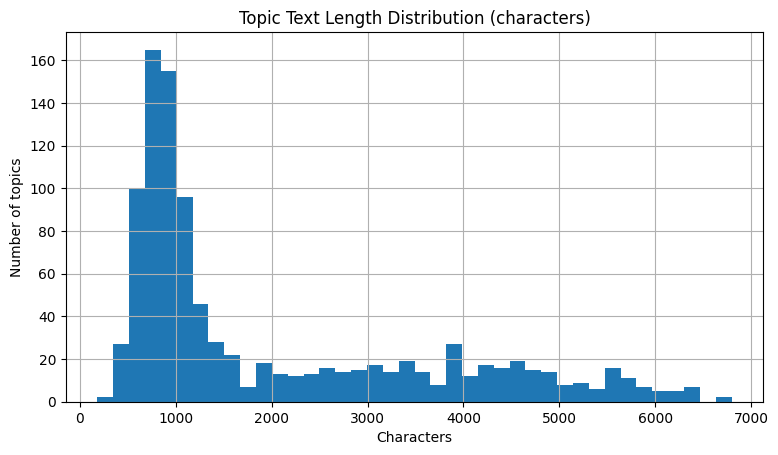

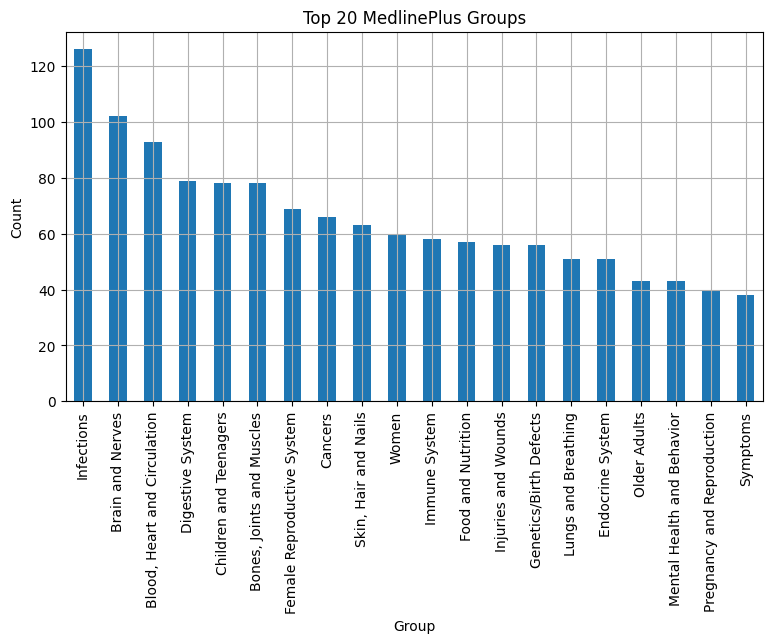

In [7]:
# 1) Distribution of topic text lengths
df["char_len"].plot(kind="hist", bins=40)
plt.title("Topic Text Length Distribution (characters)")
plt.xlabel("Characters")
plt.ylabel("Number of topics")
plt.show()

# 2) Top 20 'groups'
top_groups = (
    pd.Series([g for gl in df["groups_list"] for g in gl if g])
      .value_counts()
      .head(20)
)

top_groups.plot(kind="bar")
plt.title("Top 20 MedlinePlus Groups")
plt.xlabel("Group")
plt.ylabel("Count")
plt.show()


In [8]:
!pip install -q langchain-text-splitters
from langchain_text_splitters import RecursiveCharacterTextSplitter


In [10]:
# Cell 3: Chunk the text for better retrieval granularity
splitter = RecursiveCharacterTextSplitter(
    chunk_size=800, chunk_overlap=120, separators=["\n\n", "\n", ". ", " ", ""]
)

records = []
for _, row in df.iterrows():
    chunks = splitter.split_text(row["text"] or "")
    for j, ch in enumerate(chunks):
        records.append({
            "id": row["id"],
            "title": row["title"],
            "url": row["url"],
            "groups": row["groups"],
            "chunk_id": f'{row["id"]}_{j}',
            "text": ch
        })

corpus = pd.DataFrame(records)
print("✅ Chunked:", len(corpus), "chunks from", len(df), "topics")
corpus.head(3)


✅ Chunked: 3462 chunks from 1017 topics


,id,title,url,groups,chunk_id,text
0,6308,A1C,https://medlineplus.gov/a1c.html,Diagnostic Tests | Diabetes Mellitus,6308_0,"A1C is a blood test for type 2 diabetes and prediabetes. It measures your average blood glucose, or blood sugar, level over the past 3 months. Doctors may use the A1C alone or in combination with other diabetes tests to make a diagnosis. They also use the A1C to see how well you are managing your diabetes. This test is different from the blood sugar checks that people with diabetes do every day. Your A1C test result is given in percentages. The higher the percentage, the higher your blood sugar levels have been: A normal A1C level is below 5.7% Prediabetes is between 5.7 to 6.4%. Having prediabetes is a risk factor for getting type 2 diabetes. People with prediabetes may need retests every year"
1,6308,A1C,https://medlineplus.gov/a1c.html,Diagnostic Tests | Diabetes Mellitus,6308_1,". Having prediabetes is a risk factor for getting type 2 diabetes. People with prediabetes may need retests every year. Type 2 diabetes is above 6.5% If you have diabetes, you should have the A1C test at least twice a year. The A1C goal for many people with diabetes is below 7. It may be different for you. Ask what your goal should be. If your A1C result is too high, you may need to change your diabetes care plan. NIH: National Institute of Diabetes and Digestive and Kidney Diseases"
2,3061,Abdominal Pain,https://medlineplus.gov/abdominalpain.html,Digestive System | Symptoms,3061_0,"Your abdomen extends from below your chest to your groin. Some people call it the stomach, but your abdomen contains many other important organs. Pain in the abdomen can come from any one of them. The pain may start somewhere else, such as your chest. Severe pain doesn't always mean a serious problem. Nor does mild pain mean a problem is not serious. Call your health care provider if mild pain lasts a week or more or if you have pain with other symptoms. Get medical help immediately if: You have abdominal pain that is sudden and sharp You also have pain in your chest, neck or shoulder You're vomiting blood or have blood in your stool Your abdomen is stiff, hard and tender to touch You can't move your bowels, especially if you're also vomiting"


In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=120,
    separators=["\n\n", "\n", ". ", " ", ""]
)

records = []
for _, row in df.iterrows():
    chunks = splitter.split_text(row["text"] or "")
    for j, ch in enumerate(chunks):
        records.append({
            "topic_id": row["id"],          # ⭐ important
            "title": row["title"],
            "url": row["url"],
            "groups": row["groups"],
            "chunk_id": f"{row['id']}_{j}",
            "text": ch,
            "chunk_len": len(ch),
        })

corpus = pd.DataFrame(records)
print("Columns in corpus:", corpus.columns.tolist())
print(f"✅ Chunked {len(df)} topics into {len(corpus)} chunks")
corpus.head(3)



Columns in corpus: ['topic_id', 'title', 'url', 'groups', 'chunk_id', 'text', 'chunk_len']
✅ Chunked 1017 topics into 3462 chunks


,topic_id,title,url,groups,chunk_id,text,chunk_len
0,6308,A1C,https://medlineplus.gov/a1c.html,Diagnostic Tests | Diabetes Mellitus,6308_0,"A1C is a blood test for type 2 diabetes and prediabetes. It measures your average blood glucose, or blood sugar, level over the past 3 months. Doctors may use the A1C alone or in combination with other diabetes tests to make a diagnosis. They also use the A1C to see how well you are managing your diabetes. This test is different from the blood sugar checks that people with diabetes do every day. Your A1C test result is given in percentages. The higher the percentage, the higher your blood sugar levels have been: A normal A1C level is below 5.7% Prediabetes is between 5.7 to 6.4%. Having prediabetes is a risk factor for getting type 2 diabetes. People with prediabetes may need retests every year",703
1,6308,A1C,https://medlineplus.gov/a1c.html,Diagnostic Tests | Diabetes Mellitus,6308_1,". Having prediabetes is a risk factor for getting type 2 diabetes. People with prediabetes may need retests every year. Type 2 diabetes is above 6.5% If you have diabetes, you should have the A1C test at least twice a year. The A1C goal for many people with diabetes is below 7. It may be different for you. Ask what your goal should be. If your A1C result is too high, you may need to change your diabetes care plan. NIH: National Institute of Diabetes and Digestive and Kidney Diseases",487
2,3061,Abdominal Pain,https://medlineplus.gov/abdominalpain.html,Digestive System | Symptoms,3061_0,"Your abdomen extends from below your chest to your groin. Some people call it the stomach, but your abdomen contains many other important organs. Pain in the abdomen can come from any one of them. The pain may start somewhere else, such as your chest. Severe pain doesn't always mean a serious problem. Nor does mild pain mean a problem is not serious. Call your health care provider if mild pain lasts a week or more or if you have pain with other symptoms. Get medical help immediately if: You have abdominal pain that is sudden and sharp You also have pain in your chest, neck or shoulder You're vomiting blood or have blood in your stool Your abdomen is stiff, hard and tender to touch You can't move your bowels, especially if you're also vomiting",752


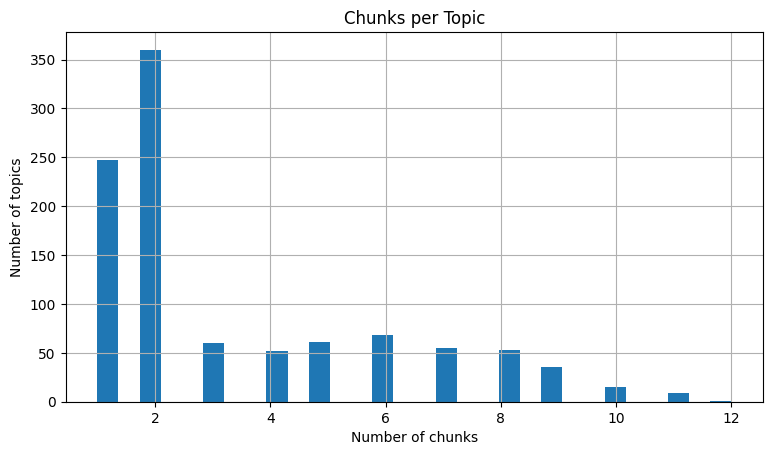

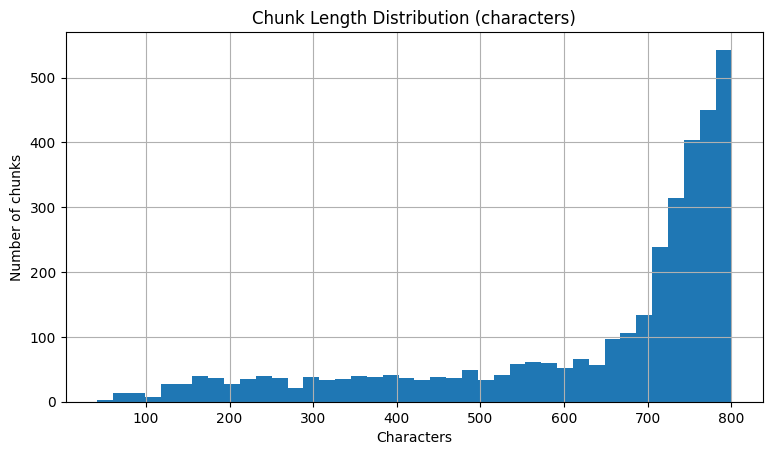

In [14]:
# Chunks per topic
chunks_per_topic = corpus.groupby("topic_id")["chunk_id"].count()
chunks_per_topic.plot(kind="hist", bins=30)
plt.title("Chunks per Topic")
plt.xlabel("Number of chunks")
plt.ylabel("Number of topics")
plt.show()

# Chunk length distribution
corpus["chunk_len"].plot(kind="hist", bins=40)
plt.title("Chunk Length Distribution (characters)")
plt.xlabel("Characters")
plt.ylabel("Number of chunks")
plt.show()


In [15]:
emb_model_name = "all-MiniLM-L6-v2"
emb_model = SentenceTransformer(emb_model_name)

emb_matrix = emb_model.encode(
    corpus["text"].tolist(),
    show_progress_bar=True,
    normalize_embeddings=True
).astype(np.float32)

print("✅ Embeddings shape:", emb_matrix.shape)


Batches:   0%|          | 0/109 [00:00<?, ?it/s]

✅ Embeddings shape: (3462, 384)


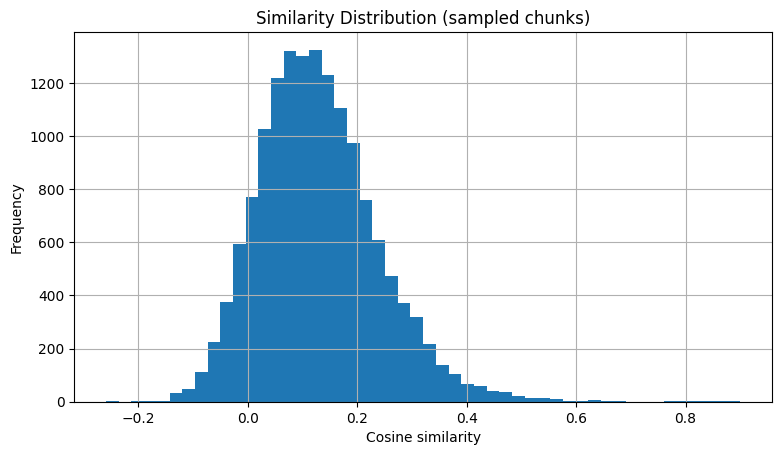

In [16]:
n = min(300, emb_matrix.shape[0])
idx = np.random.choice(emb_matrix.shape[0], size=n, replace=False)
subM = emb_matrix[idx]
sims = cosine_similarity(subM[:50], subM)  # 50 x n

vals = sims.flatten()
vals = vals[np.logical_and(vals < 0.9999, vals > -1.0)]

pd.Series(vals).plot(kind="hist", bins=50)
plt.title("Similarity Distribution (sampled chunks)")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.show()


In [17]:
def retrieve(query: str, top_k: int = 6):
    q = emb_model.encode([query], normalize_embeddings=True)
    sims = cosine_similarity(q, emb_matrix)[0]
    top_idx = np.argsort(-sims)[:top_k]
    res = corpus.iloc[top_idx].copy()
    res["score"] = sims[top_idx]
    return res[["chunk_id", "topic_id", "title", "groups", "url", "text", "score"]]

# Demo query
demo = retrieve("symptoms of type 2 diabetes", top_k=6)
demo


,chunk_id,topic_id,title,groups,url,text,score
955,5930_3,5930,Diabetes Type 2,Children and Teenagers | Endocrine System | Diabetes Mellitus,https://medlineplus.gov/diabetestype2.html,". Have a family history of diabetes Are overweight or have obesity Are Black or African American, Hispanic/Latino, American Indian, Asian American, or Pacific Islander Are not physically active Have other conditions such as high blood pressure, heart disease, stroke, polycystic ovary syndrome (PCOS), or depression Have low HDL (good) cholesterol and high triglycerides Have acanthosis nigricans - dark, thick, and velvety skin around your neck or armpits What are the symptoms of type 2 diabetes? Many people with type 2 diabetes have no symptoms at all. If you do have them, the symptoms develop slowly over several years. They might be so mild that you do not notice them",0.816313
956,5930_4,5930,Diabetes Type 2,Children and Teenagers | Endocrine System | Diabetes Mellitus,https://medlineplus.gov/diabetestype2.html,". If you do have them, the symptoms develop slowly over several years. They might be so mild that you do not notice them. The symptoms can include: Increased thirst and urination Increased hunger Feeling tired Blurred vision Numbness or tingling in the feet or hands Sores that do not heal Unexplained weight loss How is type 2 diabetes diagnosed? Your health care provider will use blood tests to diagnose type 2 diabetes. The blood tests include: A1C test, which measures your average blood sugar level over the past 3 months Fasting plasma glucose (FPG) test, which measures your current blood sugar level. You need to fast (not eat or drink anything except water) for at least 8 hours before the test. Random plasma glucose (RPG) test, which measures your current blood sugar level",0.768432
925,4_5,4,Diabetes,Older Adults | Endocrine System | Metabolic Problems | Diabetes Mellitus,https://medlineplus.gov/diabetes.html,". Are African American, Hispanic/Latino, American Indian, Alaska Native, Native Hawaiian, or Pacific Islander. What are the symptoms of diabetes? The symptoms of diabetes may include: Feeling very thirsty Feeling very hungry Urinating (peeing) more often, including at night Fatigue Blurry vision Numbness or tingling in the feet or hands Sores that do not heal Losing weight without trying But it's important to know that your symptoms may vary, depending on which type you have: The symptoms of type 1 diabetes usually come on quickly and can be severe. With type 2 diabetes, the symptoms often develop slowly, over several years. The symptoms can be so mild that you might not even notice them. Gestational diabetes often has no symptoms. If you do have symptoms, they may be mild",0.733313
950,1339_0,1339,Diabetes Type 1,Children and Teenagers | Immune System | Endocrine System | Diabetes Mellitus,https://medlineplus.gov/diabetestype1.html,"Diabetes means your blood glucose, or blood sugar, levels are too high. With type 1 diabetes, your pancreas does not make insulin. Insulin is a hormone that helps glucose get into your cells to give them energy. Without insulin, too much glucose stays in your blood. Over time, high blood glucose can lead to serious problems with your heart, eyes, kidneys, nerves, and gums and teeth. Type 1 diabetes happens most often in children and young adults but can appear at any age. Symptoms may include: Being very thirsty Urinating often Feeling very hungry or tired Losing weight without trying Having sores that heal slowly Having dry, itchy skin Losing the feeling in your feet or having tingling in your feet Having blurry eyesight A blood test can show if you have diabetes",0.697793
952,5930_0,5930,Diabetes Type 2,Children and Teenagers | Endocrine System | Diabetes Mellitus,https://medlineplus.gov/diabetestype2.html,"What is type 2 diabetes? Type 2 diabetes is a disease in which your blood glucose, or blood sugar, levels are too high. Glucose is your main source of energy. It comes from the foods you eat. A

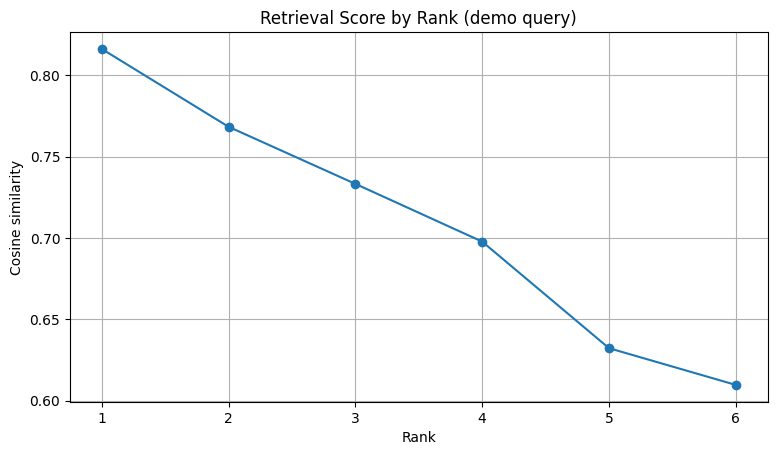

In [18]:
scores = demo["score"].values
plt.plot(range(1, len(scores)+1), scores, marker="o")
plt.title("Retrieval Score by Rank (demo query)")
plt.xlabel("Rank")
plt.ylabel("Cosine similarity")
plt.show()
